### Imports

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

### Initialize and visualize data

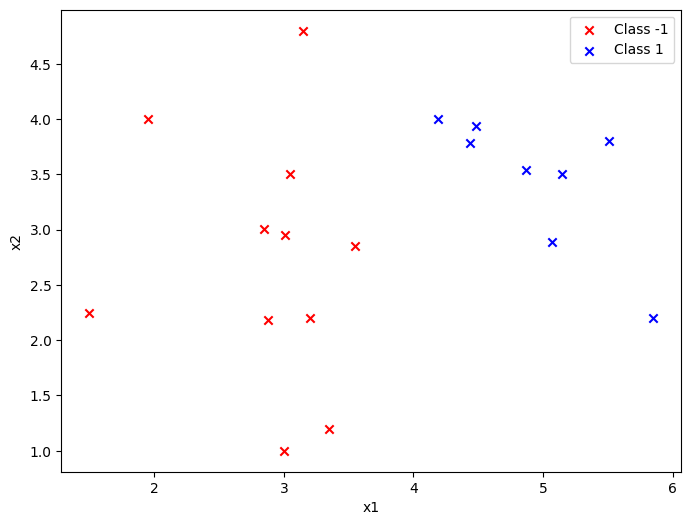

In [82]:
# Load data
def make_linear():
    """
    Generates synthetic data for SVM demonstration.
    Returns:
        X: Feature matrix (point coordinates)
        y: Label vector (class labels: -1 or 1)
    """
    # 2D data points with their coordinates
    X = np.asarray([
        [3.00, 1.00], [3.20, 2.20], [3.15, 4.80],
        [3.35, 1.20], [3.05, 3.50], [3.55, 2.85],
        [1.50, 2.25], [2.88, 2.18], [1.95, 4.00],
        [3.01, 2.95], [2.85, 3.01], [5.85, 2.20],
        [4.19, 4.00], [5.15, 3.50], [5.07, 2.89],
        [4.87, 3.54], [4.44, 3.78], [4.48, 3.94],
        [5.51, 3.80]
    ])
    y = np.asarray([
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1,
         1,  1,  1,  1,  1,  1,  1
    ])
    return X, y

X, y = make_linear()
n_samples, n_features = X.shape

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(X[y == -1, 0], X[y == -1, 1], marker='x', color='red', label='Class -1')  # Class -1 as red crosses
plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='x', color='blue', label='Class 1')  # Class 1 as blue crosses
plt.legend(loc='upper right', fontsize=10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Turning our original optimization Problem to an Quadric Optimization Problem which is required for the cvoxpt Package

$$
\begin{aligned}
\text{maximize} \quad & \sum_{i=1}^{n} \alpha_i - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j \langle x_i, x_j \rangle \\
\text{subject to} \quad & \alpha_i \geq 0 \quad (i = 1, \dots, n) \\
& \sum_{i=1}^{n} \alpha_i y_i = 0
\end{aligned}
\quad \Longrightarrow \quad
\begin{aligned}
\text{minimize} \quad & \frac{1}{2} x^\top P x + q^\top x \\
\text{subject to} \quad & A x = b \\
                        & G x \leq h
\end{aligned}
$$



### Set P Matrix


In [83]:
# P matrix for quadratic programming
# The objective function is (1/2) * w^T * P * w, where P is the identity matrix
P = np.zeros((n_features + 1, n_features + 1))  # +1 for bias term
P[:n_features, :n_features] = np.eye(n_features)  # Identity matrix for weights
P = matrix(P)  # Convert to cvxopt matrix
print(f'P Matrix:\n{P}')

P Matrix:
[ 1.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  1.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00  0.00e+00]



### Set q Matrix

In [84]:
# q vector (linear term of objective function)
q = matrix(np.zeros(n_features + 1))  # Zero vector since no linear term in objective
print(f'q Matrix:\n{q}')

q Matrix:
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]



### Set G Matrix


#### Inequality Constraint
The primal SVM requires all training examples to satisfy:
$$
y_i (\mathbf{w}^T \mathbf{x}_i + b) \geq 1 \quad \forall i
$$

In standard quadratic programming form:
$$
\begin{aligned}
\text{Subject to:} \quad & G \alpha \leq h \\
\text{Which translates to:} \quad & -y_i (\mathbf{w}^T \mathbf{x}_i + b) \leq -1 \quad \forall i
\end{aligned}
$$

In [85]:
# G matrix for inequality constraints
# Each row corresponds to constraint -y_i(w·x_i + b) <= -1
G = np.zeros((n_samples, n_features + 1))
for i in range(n_samples):
    G[i, :n_features] = -y[i] * X[i]  # Term for weights
    G[i, -1] = -y[i]  # Term for bias
G = matrix(G)  # Convert to cvxopt matrix
print(f'G Matrix:\n{G}')

G Matrix:
[ 3.00e+00  1.00e+00  1.00e+00]
[ 3.20e+00  2.20e+00  1.00e+00]
[ 3.15e+00  4.80e+00  1.00e+00]
[ 3.35e+00  1.20e+00  1.00e+00]
[ 3.05e+00  3.50e+00  1.00e+00]
[ 3.55e+00  2.85e+00  1.00e+00]
[ 1.50e+00  2.25e+00  1.00e+00]
[ 2.88e+00  2.18e+00  1.00e+00]
[ 1.95e+00  4.00e+00  1.00e+00]
[ 3.01e+00  2.95e+00  1.00e+00]
[ 2.85e+00  3.01e+00  1.00e+00]
[-5.85e+00 -2.20e+00 -1.00e+00]
[-4.19e+00 -4.00e+00 -1.00e+00]
[-5.15e+00 -3.50e+00 -1.00e+00]
[-5.07e+00 -2.89e+00 -1.00e+00]
[-4.87e+00 -3.54e+00 -1.00e+00]
[-4.44e+00 -3.78e+00 -1.00e+00]
[-4.48e+00 -3.94e+00 -1.00e+00]
[-5.51e+00 -3.80e+00 -1.00e+00]



In [86]:
# h vector for inequality constraints
h = matrix(-np.ones(n_samples))  # All entries are -1 (corresponding to -y_i(w·x_i + b) <= -1)
print(f'h Matrix:\n{h}')

h Matrix:
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]



### Optimization with solver.qp

The solver.qp function is used to solve quadratic programs like ours:

$$
\begin{aligned}
\text{minimize} \quad & \frac{1}{2} x^\top P x + q^\top x \\
\text{subject to} \quad & A x = b \\
                        & G x \leq h
\end{aligned}
$$




In [87]:
# Solve the quadratic programming problem
solution = solvers.qp(P, q, G, h)

# Extract solution
u = np.array(solution['x']).flatten()  # Solution as flat array
w = u[:n_features]  # Weight vector (w1, w2)
b = u[-1]  # Bias term (b)
print(u)


     pcost       dcost       gap    pres   dres
 0:  2.5216e-01  1.1174e+01  6e+01  2e+00  2e+01
 1:  2.5394e+00 -4.2226e+00  1e+01  3e-01  3e+00
 2:  2.9687e+00  2.3508e+00  6e-01  2e-15  3e-14
 3:  2.7195e+00  2.7089e+00  1e-02  1e-15  2e-13
 4:  2.7166e+00  2.7165e+00  1e-04  1e-15  2e-13
 5:  2.7166e+00  2.7166e+00  1e-06  1e-15  3e-13
Optimal solution found.
[  2.28337249   0.46838408 -10.44086705]


In [88]:
# Calculate support vectors
# Support vectors are points exactly on the margin (distance = 1)
distances = y * (X.dot(w) + b)  # Distances to decision boundary
support_vectors = X[np.isclose(distances, 1.0)]  # Points with distance ~1


### Plotting the SVM Hard Margin including the Support Vectors

#### Decision Boundary and Margins

We start from the decision function of a linear classifier:

$$
f(x) = \mathbf{w}^\top \mathbf{x} + b
$$

The **decision boundary** is defined where the classifier output is 0:

$$
\mathbf{w}^\top \mathbf{x} + b = 0
\quad \Longrightarrow \quad
w_0 x + w_1 y + b = 0
\quad \Longrightarrow \quad
y = -\frac{w_0 x + b}{w_1}
$$

The **SVM margins** are the hyperplanes at distance \( \pm 1 \) from the boundary:

- **Upper margin**:
  $$
  \mathbf{w}^\top \mathbf{x} + b = 1
  \quad \Longrightarrow \quad
  y = -\frac{w_0 x + b - 1}{w_1}
  $$

- **Lower margin**:
  $$
  \mathbf{w}^\top \mathbf{x} + b = -1
  \quad \Longrightarrow \quad
  y = -\frac{w_0 x + b + 1}{w_1}
  $$


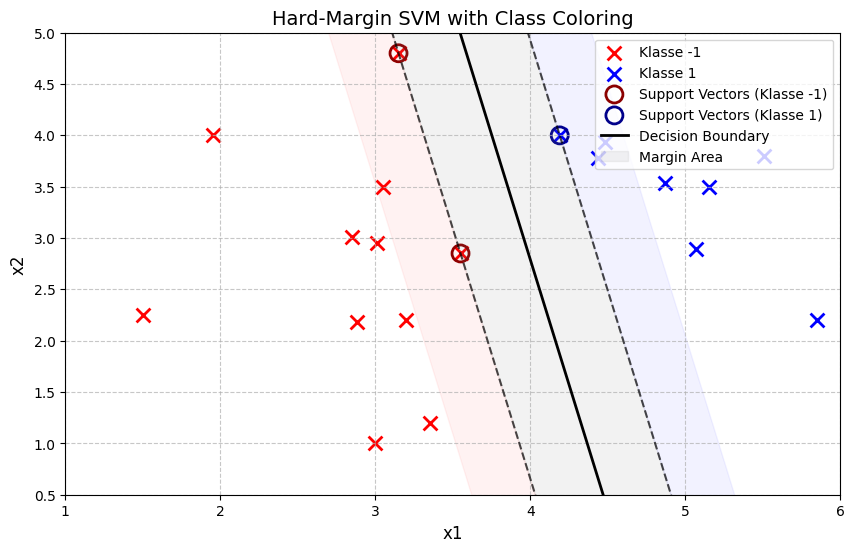

Optimal weights: w = [2.28337249 0.46838408]
Optimal bias: b = -10.4409
Number of Support Vectors: 3


In [89]:
plt.figure(figsize=(10, 6))

# Calculate decision boundary and margins
x_vals = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)  # x-values for lines
y_vals = -(w[0] * x_vals + b) / w[1]  # Decision boundary (w·x + b = 0)
margin_upper = -(w[0] * x_vals + b - 1) / w[1]  # Upper margin (w·x + b = 1)
margin_lower = -(w[0] * x_vals + b + 1) / w[1]  # Lower margin (w·x + b = -1)


class_colors = {1: 'blue', -1: 'red'}
edge_colors = {1: 'darkblue', -1: 'darkred'}


plt.scatter(X[y == -1, 0], X[y == -1, 1], 
            marker='x', color=class_colors[-1], 
            label='Klasse -1', s=100, linewidth=2)
plt.scatter(X[y == 1, 0], X[y == 1, 1], 
            marker='x', color=class_colors[1], 
            label='Klasse 1', s=100, linewidth=2)


for cls in [-1, 1]:
    cls_sv = support_vectors[y[np.isclose(distances, 1.0)] == cls]
    plt.scatter(cls_sv[:, 0], cls_sv[:, 1], 
                s=150, facecolors='none', 
                edgecolors=edge_colors[cls],
                linewidths=2, 
                label=f'Support Vectors (Klasse {cls})')



plt.plot(x_vals, y_vals, 'k-', linewidth=2, label='Decision Boundary')
plt.plot(x_vals, margin_upper, 'k--', linewidth=1.5, alpha=0.7)
plt.plot(x_vals, margin_lower, 'k--', linewidth=1.5, alpha=0.7)


plt.fill_between(x_vals, margin_lower, margin_upper, 
                 color='gray', alpha=0.1, label='Margin Area')


plt.fill_between(x_vals, margin_upper, margin_upper+2, 
                 color=class_colors[1], alpha=0.05)
plt.fill_between(x_vals, margin_lower-2, margin_lower, 
                 color=class_colors[-1], alpha=0.05)


plt.xlim(1,6)
plt.ylim(0.5,5)
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.title('Hard-Margin SVM with Class Coloring', fontsize=14)


plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


print(f"Optimal weights: w = {w}")
print(f"Optimal bias: b = {b:.4f}")
print(f"Number of Support Vectors: {len(support_vectors)}")